# Standard imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.integrate import odeint

# Custom imports that are either local or pulled from github

In [15]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# Imports related to model predictive control and pybounds

In [16]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    !pip install pybounds
    import pybounds

# Planar drone dynamics.

$
\mathbf{\dot{x}} =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

<span style="color:blue;">AI tip: try an LLM to convert picture of your dynamics to latex. It'll get much of it right, but you may need to fix it.

# Set some constant parameters (the blue symbols above)

In [17]:
m = 1 # mass (kg)
g = 9.81 # acceleration due to gravity (m/s^2)
L = 0.5 # length of the drone arm (m)
Iyy = 0.02 # moment of inertia (e.g. 1/12*m*L**2 for a solid rod, as an approximation)

# Define your dynamics function

We will use this same format many times, for evaluating observability and Kalman filters.

<span style="color:blue;">AI tip: try an LLM to convert a picture of the dynamics, or the latex code, to a python function. You may have to correct it!

In [47]:
def f(x_vec, u_vec, m=m, g=g, L=L, I=Iyy):
    """
    Continuous time dynamics function for the system shown in the equation.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector [θ, θ̇, x, ẋ, z, ż, k]
    u_vec : array-like, shape (2,)
        Control vector [j1, j2]
    L : float, default 0.5
        drone arm length
    m : float, default 1.0
        drone mass
    g : float, default 9.81
        Gravitational acceleration

    Returns:
    x_dot : numpy array, shape (7,)
        Time derivative of state vector
    """

    C = 0.5

    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ theta_dot,
                                 0,
                                 x_dot,
                                 - (x_dot) * (C * x_dot**2) / m,
                                 z_dot,
                                 (-g) * (z_dot) * (C * z_dot**2) / m,
                                 0])

    # f1 component: multiplied by control j1
    f1_contribution = j1 * np.array([0,
                                     L*k/Iyy,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0])

    # f2 component: multiplied by control j2
    f2_contribution = j2 * np.array([0,
                                     0,
                                     0,
                                     -k * np.sin(theta) / m,
                                     0,
                                     k * np.cos(theta) / m,
                                     0])

    # combined dynamics
    x_dot_vec = f0_contribution + f1_contribution + f2_contribution

    return x_dot_vec

# Make sure dynamics make sense using odeint

Use odeint to perform a simple ODE solver using a simple controller to verify that the dynamics appear to be correct.  

In [48]:
def f_ode(x_vec, tsim, u_func, f):
    '''
    Wrap dynamics function so it can be used with odeint.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector
    tsim : float
        Current time step
    u_func: function
        Control function
    f: function
        Continuous time dynamics function

    Returns:
    x_dot_vec : numpy array, shape (7,)
        Time derivative of state vector
    '''
    u_vec = u_func(x_vec, tsim)
    x_dot_vec = f(x_vec, u_vec)
    return x_dot_vec

In [49]:
def u_func(x_vec, tsim, m=m, g=g, L=L, Iyy=Iyy):
    '''
    Simple controller that aims to move the drone up, and make the angle oscillate.
    '''
    theta = x_vec[0]
    theta_des = np.sin(2*tsim)*0.1
    err = theta_des - theta
    ctrl = 10*err
    return [ctrl, m*g*1.5]

In [50]:
# sim time
dt = 0.01
tsim = np.arange(0, 8.0, step=dt)

In [51]:
# initial condition
x0 = np.array([0, 0, 0, 0, 10, 0, 1])

In [52]:
# run odeint
result = odeint(f_ode, x0, tsim, args=(u_func, f) )

### Plot some results

Based on the control function and dynamics, does this make sense?

Text(0, 0.5, 'z pos')

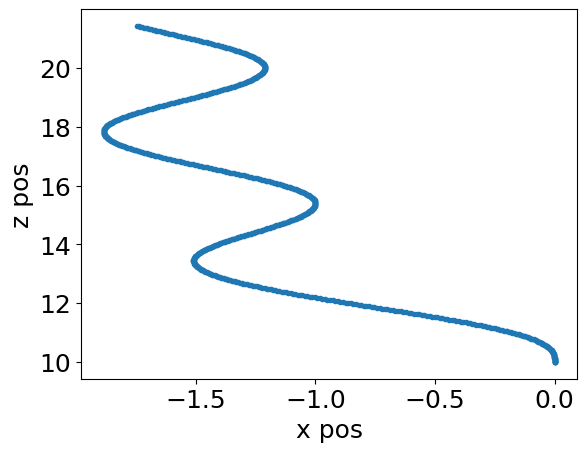

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(result[:,2], result[:,4], '.')
ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

Text(0, 0.5, 'theta')

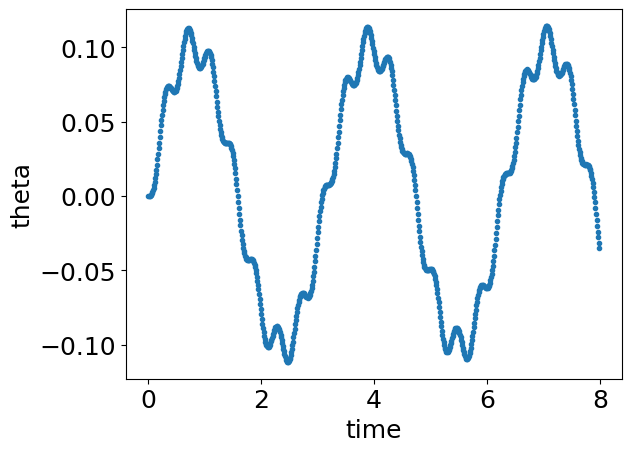

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(tsim, result[:,0], '.')
ax.set_xlabel('time')
ax.set_ylabel('theta')

# Planar drone measurements

Define a measurement function. In this case we consider $\mathbf{y}$ consisting of a downward facing camera that records ventral optic flow, and a measurement of the tilt of the planar drone.

$
\mathbf{y} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta}
\end{bmatrix}
$

In [55]:
def h(x_vec, u_vec):
    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # Measurements
    y_vec = [x_dot/z, theta]

    # Return measurement
    return y_vec

# Simulate with pybounds / MPC

In [56]:
import pybounds

In [57]:
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']
input_names = ['j1', 'j2']
measurement_names = ['optic_flow', 'theta']

In [58]:
dt = 0.1  # [s]

In [59]:
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


In [60]:
# First define the set-point(s) to follow
tsim = np.arange(0, 8.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # ground speed changes as a sinusoid
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # altitude also oscillates
            'z_dot': NA,
            'k': np.ones_like(tsim),
           }

In [61]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [62]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost_k = (simulator.model.x['k'] - simulator.model.tvp['k_set']) ** 2
cost = cost_x + cost_z #+ cost_k

In [63]:
# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

In [64]:
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0

simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

In [65]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

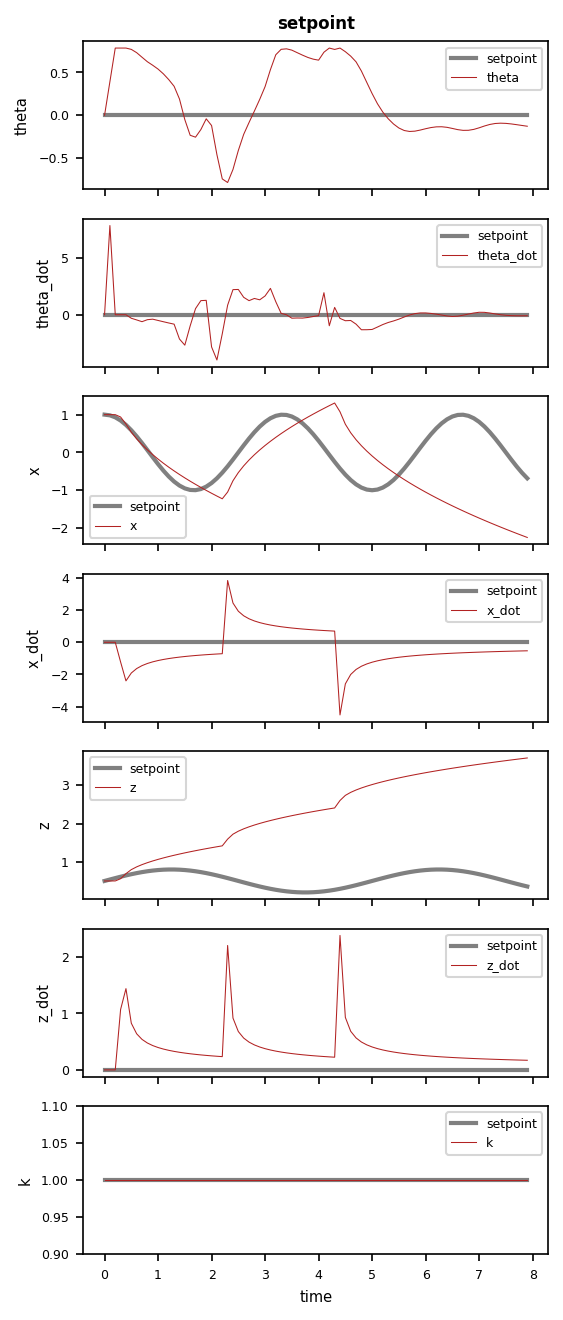

In [66]:
simulator.plot('setpoint')

# Save the trajectory

This makes is easy to load in a future notebook, for example `B_planar_drone_animation.ipynb`

We will use pandas dataframes and hdf files throughout the course. This serves as a brief introduction.

In [67]:
# turn all the sim outputs into pandas dataframes
df_x = pandas.DataFrame(x_sim) # x_sim is a dict
df_u = pandas.DataFrame(u_sim) # u_sim is a dict
df_y = pandas.DataFrame(y_sim) # y_sim is a dict
df_t = pandas.DataFrame({'t': t_sim}) # t_sim is a 1d array, make it a dict

# keep states and measurements separate since they can have conflicting names
df_states = pandas.concat([df_t, df_x, df_u], axis=1)
df_measurements = pandas.concat([df_t, df_y], axis=1)

In [68]:
df_states.to_hdf('planar_drone_sim_states.hdf', 'states')
df_measurements.to_hdf('planar_drone_sim_measurements.hdf', 'measurements')

/tmp/ipython-input-2852094502.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df_states.to_hdf('planar_drone_sim_states.hdf', 'states')
/tmp/ipython-input-2852094502.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df_measurements.to_hdf('planar_drone_sim_measurements.hdf', 'measurements')


### look at the dataframe format

In [69]:
df_states

,t,theta,theta_dot,x,x_dot,z,z_dot,k,j1,j2
0,0.0,0.000000,0.000000,1.000000,0.000000e+00,0.500000,0.000000e+00,1.0,3.141588,3.966667e-08
1,0.1,0.392699,7.853971,1.000000,-5.868254e-10,0.500000,3.877305e-09,1.0,-3.141582,2.375220e-07
2,0.2,0.785398,0.000015,1.000000,-1.458334e-08,0.500000,2.277275e-08,1.0,-0.000009,1.773038e+01
3,0.3,0.785398,-0.000007,0.937796,-1.229894e+00,0.558646,1.070738e+00,1.0,0.000006,2.166066e+01
4,0.4,0.785398,0.000007,0.750998,-2.403292e+00,0.691208,1.439371e+00,1.0,-0.123927,3.345266e-07
...,...,...,...,...,...,...,...,...,...,...
75,7.5,-0.094614,-0.049196,-2.030769,-5.635379e-01,3.645466,1.808128e-01,1.0,-0.011967,-9.083992e-09
76,7.6,-0.101030,-0.079112,-2.086682,-5.547972e-01,3.663405,1.779812e-01,1.0,-0.005131,-9.087672e-09
77,7.7,-0.109582,-0.091940,-2.141741,-5.464510e-01,3.681067,1.752786e-01,1.0,-0.000647,-9.089191e-09
78,7.8,-0.118857,-0.093557,-2.195985,-5.384706e-01,3.698465,1.726955e-01,1.0,0.001717,-9.089506e-09


# Exercises

1. Update the dynamics model to include air drag ($Drag = C*vel^2$, C is a combined drag coefficient, traditionally $C=1/2 \rho C_d A$). Does this make it "easier" or "harder" to control the drone?
2. What is the fastest you can make the drone oscillate in the x dimension?
3. What happens if you change the `rterm` in `simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)`?

## Exercise 1

# Lessons learned and next steps

### Lessons learned

1. How to simulate a nonlinear dynamical system with python and odeint
2. How to use model predictive control to drive a dynamical systems model along a desired trajectory
3. How to format data as a pandas dataframe, and save data to disk

### Next steps

1. Loading saved data
2. Making an animation

### Long term next steps

1. Use this model and trajectory to analyze observability and write a Kalman filter to estimate states given limited measurements.